In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 1. Polynomial regression
## 1.1 Try linear regression on non-linear data
### a. Utility functions

In [3]:
# Build dataset with non-linear data
def make_nonlinear_data(num_samples, seed:int=0):
    np.random.seed(seed)
    # Make data
    noise = np.random.normal(0,1, num_samples) # gaussian data, mean=0, std=1
    x = 5*np.random.rand((num_samples))        # random samples between 0 and 5
    y = 4*np.cos(x) + noise                    # generate random y, non-linear
    return x, y

In [23]:
# Draw the regression line
def plot_regression_line(reg, label="Regression line", start=0, stop=5):
    # For plots generate 50 linearly spaced samples between start and stop
    x_reg = np.linspace(start, stop, 50)
    y_reg = reg.predict(x_reg[:, np.newaxis]) # == x_reg.reshape(-1,1)
    plt.plot(x_reg, y_reg, label=label)

In [5]:
# Print R2 score, computed with cross-validation
def print_score(reg, x, y):
    y_pred = cross_val_predict(reg, x[:, np.newaxis], y, cv=5)
    print(f"R2: {r2_score(y, y_pred)}")

### b. Run regression

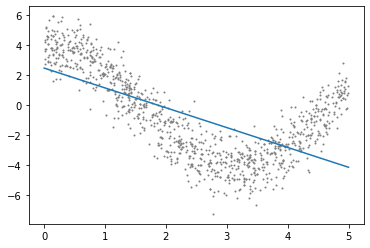

R2: 0.4194216523887825


In [20]:
# Generate data
x, y = make_nonlinear_data(1000, 123456)

# Regression (computed with all data)
reg = LinearRegression()
# reg.fit(x[:,np.newaxis], y)
reg.fit(x.reshape(-1,1), y)

# Plots
plt.scatter(x, y, s=1, c='grey')
plot_regression_line(reg)
plt.show()

# Score (using cross validation)
print_score(reg, x, y)

## 1.2 Linear regression with polynomial features

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Generate data
x, y = make_nonlinear_data(1000)

** Let's define a pipeline with PolynomialFeatures and LinearRegression**
- Try width degree = 5

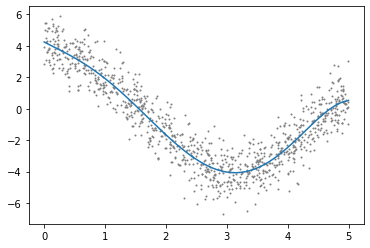

R2: 0.8703734726472482


In [22]:
# Regression (computed with all data)
reg = make_pipeline(PolynomialFeatures(5), LinearRegression())
reg.fit(x[:,np.newaxis], y)

# Plots
plt.scatter(x, y, s=1, c='grey')
plot_regression_line(reg)
plt.show()

# Score (using cross validation)
print_score(reg, x, y)

# 2. Overfitting and regularization

In [25]:
# Utility function to fit, plot the regression line, display the R2
# of a polynomial regression with parametric degree
def polynomial_regression(x, y, degree):
    # Regression (computed with all data)
    reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    reg.fit(x[:,np.newaxis], y)

    # Plots
    plt.scatter(x, y, s=1, c='grey')
    plot_regression_line(reg, label="d="+str(degree))

    # Score (using cross validation)
    print("Degree = %d" % degree)
    print_score(reg, x, y)

## 2.2 Let's try some different polynomial degrees with 1000 data points

Degree = 2
R2: 0.8081144277136435
Degree = 3
R2: 0.8546222037708919
Degree = 15
R2: 0.8687756275311938


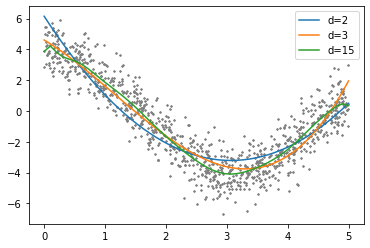

In [26]:
x, y = make_nonlinear_data(1000)
polynomial_regression(x, y, 2)
polynomial_regression(x, y, 3)
polynomial_regression(x, y, 15)    # Seems to work well
plt.legend()
plt.show()

## 2.3 Overfitting example
- Reduce data to only 60 samples

Degree = 2
R2: 0.7450449289866761
Degree = 3
R2: 0.8513635538224728
Degree = 15
R2: 0.625370559793814


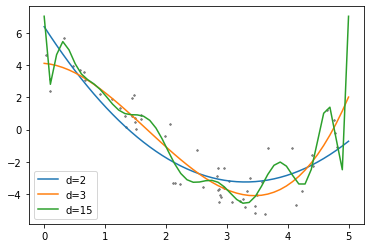

In [27]:
x, y = make_nonlinear_data(60)
polynomial_regression(x, y, 2)
polynomial_regression(x, y, 3)
polynomial_regression(x, y, 15)
plt.legend()
plt.show()

- ** Degree 3 is quite good, but degree 15 this time overfits **
- ** Higher degree is not always better!**

## 2.4 Regularization to tackle overfitting
- Define a new method for applying **Lasso** to our non-linear data

In [28]:
from sklearn.linear_model import Lasso

# Here we apply Lasso as regularized linear regression
def polynomial_regression_regularized(x, y, degree):
    # Regression (computed with all data)
    # Tolerance is the minimum scoring (R2) improvement for the algorithm to continue the optimization
    # if it is too low, the algorithm optimization may not converge
    reg = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=0.5, tol=0.2))
    reg.fit(x[:,np.newaxis], y)

    # Plots
    plt.scatter(x, y, s=1, c='grey')
    plot_regression_line(reg, label="Lasso, d=" + str(degree))

    # Score (using cross validation)
    print("Lasso, degree = %d" % degree)
    print_score(reg, x, y)

Degree = 15
R2: 0.625370559793814
Lasso, degree = 15
R2: 0.8085930319001831


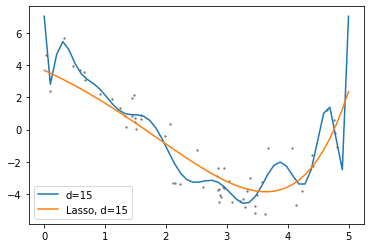

In [29]:
x, y = make_nonlinear_data(60)
poly = polynomial_regression(x, y, 15)
poly_reg = polynomial_regression_regularized(x, y, 15)
plt.legend()
plt.show()

Lasso achieves better R2 rather than common linear regression.

# 3. Grid-search to select model hyperparameters
## Important:
- Test data must not be used during hyperparameter selection
- If you use it to tune parameters, there is the risk of overfitting the test-set
- 2 possibilities:
- a. Divide your data in: training, validation and test set
    - **Training**: used to train model configurations
    - **Validation**: used to verify which model configuration is the best
    - **final model** = train the selected configuration on (Training U Validation)
    - **Test**: used to asses the quality of the final
- b. Divide your data in: training test set
    - **Training**: perform cross-validation on this set to select the best model based on some score
    - **final model** = train the selected configuration on the complete training set
    - **Test**: used to asses the quality of the final model
- Using cross-validation (b) is **slower**, but **less prone to overfitting**, because it chooses the best model based on a score that is averaged between multiple train-validation splits.

### 3.1 Let's try to implement the second version (b).
### First, make some data

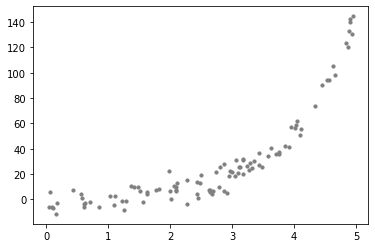

In [30]:
# Build dataset with non-linear data
def make_nonlinear_data2(num_samples):
    np.random.seed(123456)
    # Make data
    err = np.random.normal(0,6, num_samples)
    x = 5*np.random.rand((num_samples))        
    y = np.exp(x) + err     
    return x, y

# Generate dataset
x, y = make_nonlinear_data2(100)
plt.scatter(x, y, s=10, c='grey')
plt.show()

### 3.2 Now configure the grid-search

In [31]:
# Regression model that we want to configure:
reg = make_pipeline(PolynomialFeatures(), Lasso(tol=0.4))

# Parameter grid
# Specify in a dictionary a key for each parameter to be configured and the list of its values
# The keys in the dictionary must match the parameter names of the model constructor
# In the case of pipelines (chain of models) specify the name of the model, two underscores
# and the parameter name.
# Example:
param_grid = {'polynomialfeatures__degree':list(range(2,20,2)), 
              'lasso__alpha':[1e-2, 0.1, 1]}

In [32]:
from sklearn.model_selection import GridSearchCV
    
# Configure grid search with the model and the parameter grid
# The best model is computed based on the scoring function (R2) and with cross-validation (cv)
gridsearch = GridSearchCV(reg, param_grid, scoring='r2', cv=5)

### 3.3 Apply cross-validation on training data to find the best configuration

In [33]:
# Make data (training, test set)
x_train, x_test, y_train, y_test = train_test_split(x, y)

# Optimize the model parameters with cross-validation on the training data
# The best model configuration is the one with highest average R2 score
# (R2 is averaged among all the cross-validation partitions)
res = gridsearch.fit(x_train[:, np.newaxis], y_train)

# Print result
print("Best model configuration is:")
print(res.best_params_)
print("with R2=%.2f" % res.best_score_)

Best model configuration is:
{'lasso__alpha': 1, 'polynomialfeatures__degree': 18}
with R2=0.98


### 3.4 Train the selected configuration on the complete training set

R2 (test set): 0.93


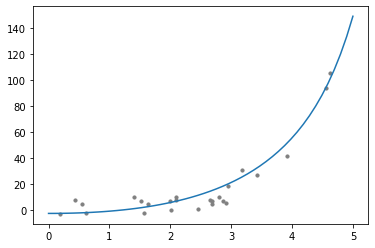

In [34]:
# Take the best model configuration
final_model = res.best_estimator_

# Plot result
plt.scatter(x_test, y_test, s=10, c='grey')
plot_regression_line(final_model)

# Evaluate on test set
y_test_pred = final_model.predict(x_test[:,np.newaxis])
r2 = r2_score(y_test, y_test_pred)
print("R2 (test set): %.2f" % r2)